<a href="https://colab.research.google.com/github/JuNoe2020/DMC_class_2021/blob/main/Deep_Learning_code_review/%EC%84%B1%EB%8A%A5%ED%83%90%EC%83%89_%EA%BD%83_%EB%B6%84%EB%A5%98_%EB%8D%B0%EC%9D%B4%ED%84%B0%EC%A6%9D%EA%B0%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 데이터 로딩함수

In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications import vgg16

In [ ]:
def load_file_names_and_category_names(path):
  
  file_names = []
  category_names = []

  dir_names = os.listdir(path)
      
  for dir_name in dir_names:
    file_names_in_a_dir = os.listdir(path+"/"+dir_name)

    for a_file_name in file_names_in_a_dir:
      full_file_name = path+"/"+dir_name+"/"+a_file_name
      file_names.append(full_file_name)
      category_names.append(dir_name)

  combined = list(zip(file_names, category_names))
  random.shuffle(combined)
  file_names, category_names = zip(*combined)

  return file_names, category_names


def load_image_files_into_numpy_array(file_names):
  file_count = len(file_names)    
  data = np.ndarray(shape=(file_count,224,224,3), dtype=np.float64)    
  for i in range(len(file_names)):
    image = load_img(file_names[i], target_size=(224, 224))
    image = img_to_array(image)
    data[i] = image
  return data


def load_custom_data(path, train_ratio=0.8):
  
  file_names, category_names = load_file_names_and_category_names(path)
  x = load_image_files_into_numpy_array(file_names)
  
  labels, y = np.unique(category_names, return_inverse=True)  

  s = int(x.shape[0]*train_ratio)
  train_x, test_x = x[:s], x[s:]
  train_y, test_y = y[:s], y[s:]
  
  return (train_x, train_y), (test_x, test_y), labels


# 라이브러리 불러오기

In [ ]:
import os

import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

from tensorflow.keras.applications import vgg16
from tensorflow.keras.applications import VGG16

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.layers import BatchNormalization


# 실시간 로스 체크 함수

In [ ]:
# copy from https://gist.github.com/stared/dfb4dfaf6d9a8501cd1cc8b8cb806d2e
from tensorflow.keras.callbacks import Callback
from IPython.display import clear_output

class PlotLosses(Callback):

  def on_train_begin(self, logs={}):

    self.i = 0
    self.x = []
    self.losses = []
    self.val_losses = []
    self.acc = []
    self.val_acc = []

    self.fig = plt.figure()

    self.logs = []


  def on_epoch_end(self, epoch, logs={}):

    self.logs.append(logs)
    self.x.append(self.i)
    self.losses.append(logs.get('loss'))
    self.val_losses.append(logs.get('val_loss'))
    self.acc.append(logs.get('acc'))
    self.val_acc.append(logs.get('val_acc'))
    self.i += 1

    clear_output(wait=True)
    plt.plot(self.x, self.losses, label="loss")
    plt.plot(self.x, self.val_losses, label="val_loss")
    plt.plot(self.x, self.acc, label="acc")
    plt.plot(self.x, self.val_acc, label="val_acc")
    plt.legend()
    plt.show();
    print("loss = ", self.losses[-1], ", val_loss = ", self.val_losses[-1])
    print("acc = ", self.acc[-1], ", val_acc = ", self.val_acc[-1])



# vgg16/ 390 x 390

In [ ]:
(train_x, train_y), (test_x, test_y), custom_labels = load_custom_data("data/2flowers_")

train_x = vgg16.preprocess_input(train_x)
test_x = vgg16.preprocess_input(test_x)

print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)
print(custom_labels)  

(451, 224, 224, 3)
(451,)
(113, 224, 224, 3)
(113,)
['daisy' 'dandelion']


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# callbacks
model_check_point = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)
plot_losses = PlotLosses()
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.0001)

callbacks = [model_check_point, plot_losses, early_stopping, reduce_lr]

In [ ]:
conv_layers = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
conv_layers.trainable = False

model = models.Sequential()

model.add(conv_layers)
model.add(layers.Flatten())
model.add(layers.Dense(390, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(390, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(2, activation='softmax'))

# optimizer = Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
model.compile(loss='sparse_categorical_crossentropy', optimizer='SGD', metrics=['acc'])


# train_data_generator = ImageDataGenerator(
#       rotation_range=10,
#       width_shift_range=0.1,
#       height_shift_range=0.1,
#       horizontal_flip=True,
#       vertical_flip=False,
#       preprocessing_function=vgg16.preprocess_input
# ).flow_from_directory(
#       "data/2flowers/train",
#       target_size=(224,224),
#       batch_size=64,
#       class_mode='sparse'
# )

# test_data_generator = ImageDataGenerator(
#       preprocessing_function=vgg16.preprocess_input
# ).flow_from_directory(
#       "data/2flowers/test",
#       target_size=(224,224),
#       batch_size=64,
#       class_mode='sparse'
# )

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_7 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_18 (Dense)             (None, 390)               9784710   
_________________________________________________________________
batch_normalization_11 (Batc (None, 390)               1560      
_________________________________________________________________
dropout_11 (Dropout)         (None, 390)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 390)               152490    
_________________________________________________________________
batch_normalization_12 (Batc (None, 390)              

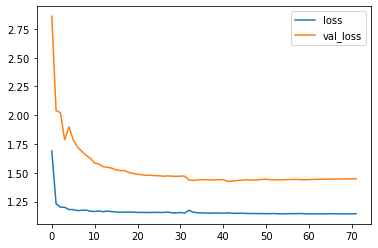

loss =  1.1445517539978027 , val_loss =  1.4469677209854126
Epoch 00072: early stopping
4/4 [==============================] - 1s 136ms/step - loss: 1.3610 - acc: 0.9558


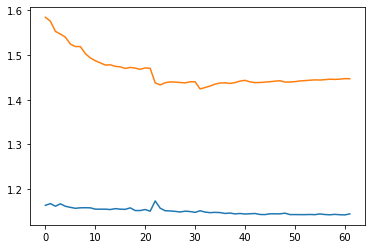

loss= 1.361038327217102
acc= 0.9557521939277649


In [ ]:
hist = model.fit(
#     train_data_generator,
      train_x,
      train_y,
#       validation_data=test_data_generator,
      validation_split=0.1,
#       steps_per_epoch=train_data_generator.samples/64,  
      shuffle=True, 
#       validation_split=0.2,    
      batch_size=64,
      epochs=100,
      callbacks = callbacks,
#       class_weight = class_weight
)

loss, acc = model.evaluate(
      test_x,
      test_y
#       steps=test_data_generator.samples/64
)

plt.plot(hist.history['loss'][10:])
plt.plot(hist.history['val_loss'][10:])
plt.show()

print("loss=", loss)
print("acc=", acc)

## train 데이터 증강을 통한 훈련

In [ ]:
(raw_train_x, raw_train_y), (raw_test_x, raw_test_y), custom_labels = load_custom_data("data/2flowers_")

pre_train_x = vgg16.preprocess_input(raw_train_x)
test_x = vgg16.preprocess_input(raw_test_x)
pre_train_y = raw_train_y
test_y = raw_test_y

print(pre_train_x.shape)
print(pre_train_y.shape)
print(test_x.shape)
print(test_y.shape)
print(custom_labels)  

(451, 224, 224, 3)
(451,)
(113, 224, 224, 3)
(113,)
['daisy' 'dandelion']


In [ ]:
from sklearn.model_selection import train_test_split

train_x, validation_x, train_y, validation_y = train_test_split(pre_train_x, pre_train_y, test_size=0.1, random_state=42)
print(train_x.shape)
print(train_y.shape)
print(validation_x.shape)
print(validation_y.shape)
print(custom_labels)  

(405, 224, 224, 3)
(405,)
(46, 224, 224, 3)
(46,)
['daisy' 'dandelion']


In [ ]:
conv_layers = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
conv_layers.trainable = False

model = models.Sequential()

model.add(conv_layers)
model.add(layers.Flatten())
model.add(layers.Dense(390, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(390, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(2, activation='softmax'))

# optimizer = Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
model.compile(loss='sparse_categorical_crossentropy', optimizer='SGD', metrics=['acc'])


data_aug_generator = ImageDataGenerator(
      rotation_range=10,
      width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True,
      vertical_flip=False,
      preprocessing_function=vgg16.preprocess_input # 여기에 preprocess 함수를 설정
)
# test_data_generator = ImageDataGenerator(
#       preprocessing_function=vgg16.preprocess_input
# ).flow_from_directory(
#       "data/2flowers/test",
#       target_size=(224,224),
#       batch_size=64,
#       class_mode='sparse'
# )

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 390)               9784710   
_________________________________________________________________
batch_normalization_6 (Batch (None, 390)               1560      
_________________________________________________________________
dropout_6 (Dropout)          (None, 390)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 390)               152490    
_________________________________________________________________
batch_normalization_7 (Batch (None, 390)              

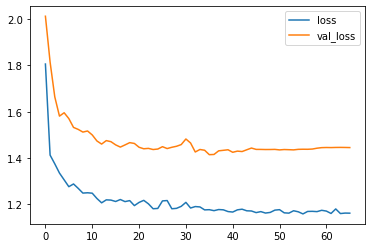

loss =  1.1621953248977661 , val_loss =  1.445530891418457
Epoch 00066: early stopping
4/4 [==============================] - 1s 146ms/step - loss: 1.4550 - acc: 0.8850


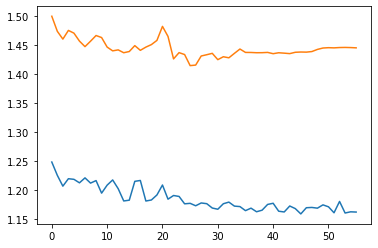

loss= 1.4550375938415527
acc= 0.8849557638168335


In [ ]:
hist = model.fit(
      data_aug_generator.flow(train_x, train_y, batch_size=64),
      validation_data=(validation_x, validation_y),
      steps_per_epoch=train_x.shape[0]/64,
      shuffle=True, 
#       validation_split=0.2,    
#       batch_size=64,
      epochs=100,
      callbacks = callbacks,
#       class_weight = class_weight
)

loss, acc = model.evaluate(
      test_x,
      test_y
#       steps=test_data_generator.samples/64
)

plt.plot(hist.history['loss'][10:])
plt.plot(hist.history['val_loss'][10:])
plt.show()

print("loss=", loss)
print("acc=", acc)

## 1개의 히든레이어을 통한 학습

In [ ]:
(train_x, train_y), (test_x, test_y), custom_labels = load_custom_data("data/2flowers_")

train_x = vgg16.preprocess_input(train_x)
test_x = vgg16.preprocess_input(test_x)

print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)
print(custom_labels)  

(451, 224, 224, 3)
(451,)
(113, 224, 224, 3)
(113,)
['daisy' 'dandelion']


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# callbacks
model_check_point = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)
plot_losses = PlotLosses()
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.0001)

callbacks = [model_check_point, plot_losses, early_stopping, reduce_lr]

In [ ]:
conv_layers = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
conv_layers.trainable = False

model = models.Sequential()

model.add(conv_layers)
model.add(layers.Flatten())
model.add(layers.Dense(390, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.2))
# model.add(layers.Dense(390, activation='relu', kernel_regularizer=l2(0.001)))
# model.add(BatchNormalization())
# model.add(layers.Dropout(0.2))
model.add(layers.Dense(2, activation='softmax'))

# optimizer = Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
model.compile(loss='sparse_categorical_crossentropy', optimizer='SGD', metrics=['acc'])


# train_data_generator = ImageDataGenerator(
#       rotation_range=10,
#       width_shift_range=0.1,
#       height_shift_range=0.1,
#       horizontal_flip=True,
#       vertical_flip=False,
#       preprocessing_function=vgg16.preprocess_input
# ).flow_from_directory(
#       "data/2flowers/train",
#       target_size=(224,224),
#       batch_size=64,
#       class_mode='sparse'
# )

# test_data_generator = ImageDataGenerator(
#       preprocessing_function=vgg16.preprocess_input
# ).flow_from_directory(
#       "data/2flowers/test",
#       target_size=(224,224),
#       batch_size=64,
#       class_mode='sparse'
# )

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_5 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_14 (Dense)             (None, 390)               9784710   
_________________________________________________________________
batch_normalization_9 (Batch (None, 390)               1560      
_________________________________________________________________
dropout_9 (Dropout)          (None, 390)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 782       
Total params: 24,501,740
Trainable params: 9,786,272
Non-trainable params: 14,715,468
__________________________________

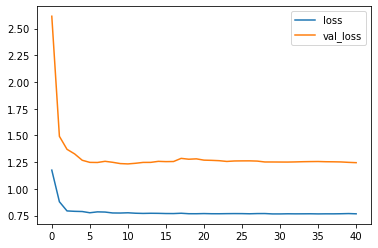

loss =  0.76612389087677 , val_loss =  1.2446683645248413
Epoch 00041: early stopping
4/4 [==============================] - 1s 145ms/step - loss: 0.9589 - acc: 0.9204


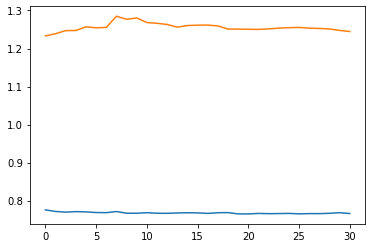

loss= 0.9589419960975647
acc= 0.9203540086746216


In [ ]:
hist = model.fit(
#     train_data_generator,
      train_x,
      train_y,
#       validation_data=test_data_generator,
      validation_split=0.1,
#       steps_per_epoch=train_data_generator.samples/64,  
      shuffle=True, 
#       validation_split=0.2,    
      batch_size=64,
      epochs=100,
      callbacks = callbacks,
#       class_weight = class_weight
)

loss, acc = model.evaluate(
      test_x,
      test_y
#       steps=test_data_generator.samples/64
)

plt.plot(hist.history['loss'][10:])
plt.plot(hist.history['val_loss'][10:])
plt.show()

print("loss=", loss)
print("acc=", acc)

## 1개의 히든레이어, 노드 100개

In [ ]:
(train_x, train_y), (test_x, test_y), custom_labels = load_custom_data("data/2flowers_")

train_x = vgg16.preprocess_input(train_x)
test_x = vgg16.preprocess_input(test_x)

print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)
print(custom_labels)  

(451, 224, 224, 3)
(451,)
(113, 224, 224, 3)
(113,)
['daisy' 'dandelion']


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# callbacks
model_check_point = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)
plot_losses = PlotLosses()
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.0001)

callbacks = [model_check_point, plot_losses, early_stopping, reduce_lr]

In [ ]:
conv_layers = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
conv_layers.trainable = False

model = models.Sequential()

model.add(conv_layers)
model.add(layers.Flatten())
model.add(layers.Dense(390, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.2))
# model.add(layers.Dense(390, activation='relu', kernel_regularizer=l2(0.001)))
# model.add(BatchNormalization())
# model.add(layers.Dropout(0.2))
model.add(layers.Dense(2, activation='softmax'))

# optimizer = Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
model.compile(loss='sparse_categorical_crossentropy', optimizer='SGD', metrics=['acc'])


# train_data_generator = ImageDataGenerator(
#       rotation_range=10,
#       width_shift_range=0.1,
#       height_shift_range=0.1,
#       horizontal_flip=True,
#       vertical_flip=False,
#       preprocessing_function=vgg16.preprocess_input
# ).flow_from_directory(
#       "data/2flowers/train",
#       target_size=(224,224),
#       batch_size=64,
#       class_mode='sparse'
# )

# test_data_generator = ImageDataGenerator(
#       preprocessing_function=vgg16.preprocess_input
# ).flow_from_directory(
#       "data/2flowers/test",
#       target_size=(224,224),
#       batch_size=64,
#       class_mode='sparse'
# )

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_6 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_16 (Dense)             (None, 390)               9784710   
_________________________________________________________________
batch_normalization_10 (Batc (None, 390)               1560      
_________________________________________________________________
dropout_10 (Dropout)         (None, 390)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 2)                 782       
Total params: 24,501,740
Trainable params: 9,786,272
Non-trainable params: 14,715,468
__________________________________

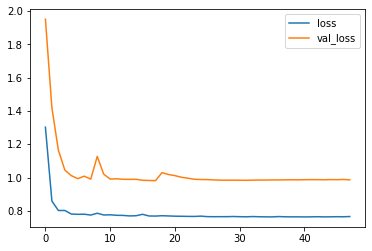

loss =  0.7657735347747803 , val_loss =  0.9862245321273804
Epoch 00048: early stopping
4/4 [==============================] - 1s 146ms/step - loss: 0.9556 - acc: 0.9204


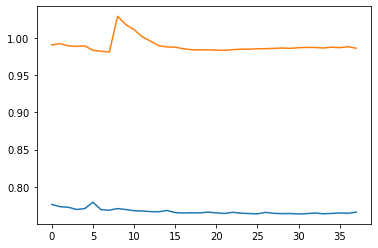

loss= 0.9556313753128052
acc= 0.9203540086746216


In [ ]:
hist = model.fit(
#     train_data_generator,
      train_x,
      train_y,
#       validation_data=test_data_generator,
      validation_split=0.1,
#       steps_per_epoch=train_data_generator.samples/64,  
      shuffle=True, 
#       validation_split=0.2,    
      batch_size=64,
      epochs=100,
      callbacks = callbacks,
#       class_weight = class_weight
)

loss, acc = model.evaluate(
      test_x,
      test_y
#       steps=test_data_generator.samples/64
)

plt.plot(hist.history['loss'][10:])
plt.plot(hist.history['val_loss'][10:])
plt.show()

print("loss=", loss)
print("acc=", acc)

# Xception

In [ ]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import xception

In [ ]:
(train_x, train_y), (test_x, test_y), custom_labels = load_custom_data("data/2flowers_")

train_x = xception.preprocess_input(train_x)
test_x = xception.preprocess_input(test_x)

print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)
print(custom_labels)  

(451, 224, 224, 3)
(451,)
(113, 224, 224, 3)
(113,)
['daisy' 'dandelion']


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# callbacks
model_check_point = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)
plot_losses = PlotLosses()
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.0001)

callbacks = [model_check_point, plot_losses, early_stopping, reduce_lr]

In [ ]:
conv_layers = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
conv_layers.trainable = False

model = models.Sequential()

model.add(conv_layers)
model.add(layers.Flatten())
model.add(layers.Dense(99, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(99, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(2, activation='softmax'))

# optimizer = Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
model.compile(loss='sparse_categorical_crossentropy', optimizer='SGD', metrics=['acc'])


model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
flatten_9 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_24 (Dense)             (None, 99)                9934947   
_________________________________________________________________
batch_normalization_23 (Batc (None, 99)                396       
_________________________________________________________________
dropout_15 (Dropout)         (None, 99)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 99)                9900      
_________________________________________________________________
batch_normalization_24 (Batc (None, 99)               

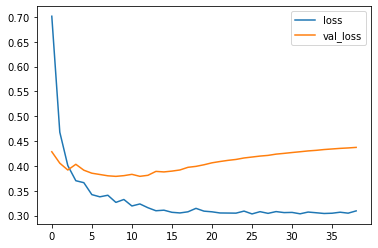

loss =  0.30929550528526306 , val_loss =  0.437185674905777
Epoch 00039: early stopping
4/4 [==============================] - 1s 156ms/step - loss: 0.3902 - acc: 0.9646


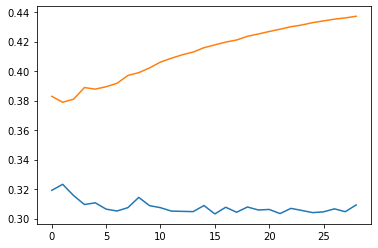

loss= 0.3901650309562683
acc= 0.9646017551422119


In [ ]:
hist = model.fit(
#     train_data_generator,
      train_x,
      train_y,
#       validation_data=test_data_generator,
      validation_split=0.1,
#       steps_per_epoch=train_data_generator.samples/64,  
      shuffle=True, 
#       validation_split=0.2,    
      batch_size=64,
      epochs=100,
      callbacks = callbacks,
      verbose = 1
#       class_weight = class_weight
)

loss, acc = model.evaluate(
      test_x,
      test_y
#       steps=test_data_generator.samples/64
)

plt.plot(hist.history['loss'][10:])
plt.plot(hist.history['val_loss'][10:])
plt.show()

print("loss=", loss)
print("acc=", acc)

# DenseNet121

## 히든레이어 100 x 100

In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications import densenet

In [ ]:
(train_x, train_y), (test_x, test_y), custom_labels = load_custom_data("data/2flowers_")

train_x = densenet.preprocess_input(train_x)
test_x = densenet.preprocess_input(test_x)

print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)
print(custom_labels)  

(451, 224, 224, 3)
(451,)
(113, 224, 224, 3)
(113,)
['daisy' 'dandelion']


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# callbacks
model_check_point = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)
plot_losses = PlotLosses()
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.0001)

callbacks = [model_check_point, plot_losses, early_stopping, reduce_lr]

In [ ]:
conv_layers = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
conv_layers.trainable = False

model = models.Sequential()

model.add(conv_layers)
model.add(layers.Flatten())
model.add(layers.Dense(100, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(100, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(2, activation='softmax'))

# optimizer = Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
model.compile(loss='sparse_categorical_crossentropy', optimizer='SGD', metrics=['acc'])


model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 7, 7, 1024)        7037504   
_________________________________________________________________
flatten_12 (Flatten)         (None, 50176)             0         
_________________________________________________________________
dense_33 (Dense)             (None, 100)               5017700   
_________________________________________________________________
batch_normalization_33 (Batc (None, 100)               400       
_________________________________________________________________
dropout_21 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 100)               10100     
_________________________________________________________________
batch_normalization_34 (Batc (None, 100)             

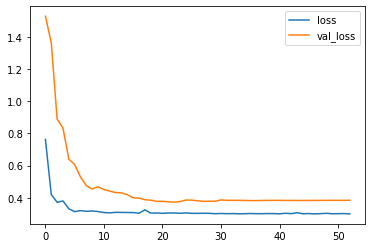

loss =  0.30001702904701233 , val_loss =  0.3846239745616913
Epoch 00053: early stopping
4/4 [==============================] - 3s 452ms/step - loss: 0.4384 - acc: 0.9558


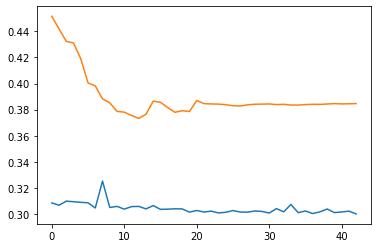

loss= 0.43841177225112915
acc= 0.9557521939277649


In [ ]:
hist = model.fit(
#     train_data_generator,
      train_x,
      train_y,
#       validation_data=test_data_generator,
      validation_split=0.1,
#       steps_per_epoch=train_data_generator.samples/64,  
      shuffle=True, 
#       validation_split=0.2,    
      batch_size=64,
      epochs=100,
      callbacks = callbacks,
      verbose = 1
#       class_weight = class_weight
)

loss, acc = model.evaluate(
      test_x,
      test_y
#       steps=test_data_generator.samples/64
)

plt.plot(hist.history['loss'][10:])
plt.plot(hist.history['val_loss'][10:])
plt.show()

print("loss=", loss)
print("acc=", acc)

## 히든레이어 58 X 58

In [ ]:
conv_layers = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
conv_layers.trainable = False

model = models.Sequential()

model.add(conv_layers)
model.add(layers.Flatten())
model.add(layers.Dense(58, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(58, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(2, activation='softmax'))

# optimizer = Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
model.compile(loss='sparse_categorical_crossentropy', optimizer='SGD', metrics=['acc'])


model.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 7, 7, 1024)        7037504   
_________________________________________________________________
flatten_25 (Flatten)         (None, 50176)             0         
_________________________________________________________________
dense_72 (Dense)             (None, 58)                2910266   
_________________________________________________________________
batch_normalization_59 (Batc (None, 58)                232       
_________________________________________________________________
dropout_47 (Dropout)         (None, 58)                0         
_________________________________________________________________
dense_73 (Dense)             (None, 58)                3422      
_________________________________________________________________
batch_normalization_60 (Batc (None, 58)              

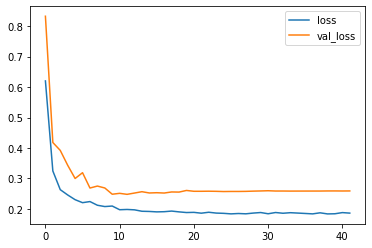

loss =  0.1862976998090744 , val_loss =  0.2590526044368744
Epoch 00042: early stopping
4/4 [==============================] - 0s 113ms/step - loss: 0.3025 - acc: 0.9558


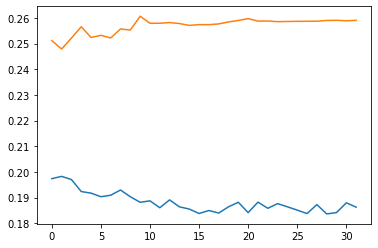

loss= 0.3025193214416504
acc= 0.9557521939277649


In [ ]:
hist = model.fit(
#     train_data_generator,
      train_x,
      train_y,
#       validation_data=test_data_generator,
      validation_split=0.1,
#       steps_per_epoch=train_data_generator.samples/64,  
      shuffle=True, 
#       validation_split=0.2,    
      batch_size=64,
      epochs=100,
      callbacks = callbacks,
      verbose = 1
#       class_weight = class_weight
)

loss, acc = model.evaluate(
      test_x,
      test_y
#       steps=test_data_generator.samples/64
)

plt.plot(hist.history['loss'][10:])
plt.plot(hist.history['val_loss'][10:])
plt.show()

print("loss=", loss)
print("acc=", acc)

# EfficientNetB2

## 히든레이어 30 x 30

In [ ]:
from tensorflow.keras.applications import EfficientNetB2
from tensorflow.keras.applications import efficientnet

In [ ]:
(train_x, train_y), (test_x, test_y), custom_labels = load_custom_data("data/2flowers_")

train_x = efficientnet.preprocess_input(train_x)
test_x = efficientnet.preprocess_input(test_x)

print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)
print(custom_labels)  

(451, 224, 224, 3)
(451,)
(113, 224, 224, 3)
(113,)
['daisy' 'dandelion']


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# callbacks
model_check_point = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)
plot_losses = PlotLosses()
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.0001)

callbacks = [model_check_point, plot_losses, early_stopping, reduce_lr]

In [ ]:
conv_layers = EfficientNetB2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
conv_layers.trainable = False

model = models.Sequential()

model.add(conv_layers)
model.add(layers.Flatten())
model.add(layers.Dense(30, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(30, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(2, activation='softmax'))

# optimizer = Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
model.compile(loss='sparse_categorical_crossentropy', optimizer='SGD', metrics=['acc'])


model.summary()

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb2 (Functional)  (None, 7, 7, 1408)        7768569   
_________________________________________________________________
flatten_34 (Flatten)         (None, 68992)             0         
_________________________________________________________________
dense_99 (Dense)             (None, 30)                2069790   
_________________________________________________________________
batch_normalization_77 (Batc (None, 30)                120       
_________________________________________________________________
dropout_65 (Dropout)         (None, 30)                0         
_________________________________________________________________
dense_100 (Dense)            (None, 30)                930       
_________________________________________________________________
batch_normalization_78 (Batc (None, 30)              

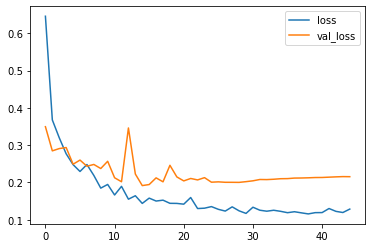

loss =  0.12865744531154633 , val_loss =  0.2154824584722519
Epoch 00045: early stopping
4/4 [==============================] - 2s 307ms/step - loss: 0.2617 - acc: 0.9292


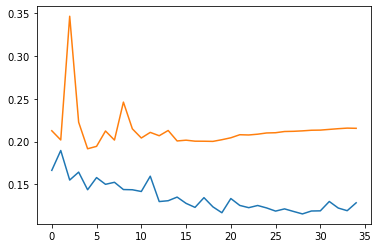

loss= 0.26171648502349854
acc= 0.9292035102844238


In [ ]:
hist = model.fit(
#     train_data_generator,
      train_x,
      train_y,
#       validation_data=test_data_generator,
      validation_split=0.1,
#       steps_per_epoch=train_data_generator.samples/64,  
      shuffle=True, 
#       validation_split=0.2,    
      batch_size=64,
      epochs=100,
      callbacks = callbacks,
      verbose = 1
#       class_weight = class_weight
)

loss, acc = model.evaluate(
      test_x,
      test_y
#       steps=test_data_generator.samples/64
)

plt.plot(hist.history['loss'][10:])
plt.plot(hist.history['val_loss'][10:])
plt.show()

print("loss=", loss)
print("acc=", acc)

# MobileNetV2

## 히든레이어 100 x 100

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import mobilenet_v2

In [ ]:
(train_x, train_y), (test_x, test_y), custom_labels = load_custom_data("data/2flowers_")

train_x = mobilenet_v2.preprocess_input(train_x)
test_x = mobilenet_v2.preprocess_input(test_x)

print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)
print(custom_labels)  

(451, 224, 224, 3)
(451,)
(113, 224, 224, 3)
(113,)
['daisy' 'dandelion']


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# callbacks
model_check_point = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)
plot_losses = PlotLosses()
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.00001)

callbacks = [model_check_point, plot_losses, early_stopping, reduce_lr]

In [ ]:
conv_layers = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
conv_layers.trainable = False

model = models.Sequential()

model.add(conv_layers)
model.add(layers.Flatten())
model.add(layers.Dense(100, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(100, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(2, activation='softmax'))

# optimizer = Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
model.compile(loss='sparse_categorical_crossentropy', optimizer='SGD', metrics=['acc'])


model.summary()

9412608/9406464 [==============================] - 0s 0us/step
Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten_35 (Flatten)         (None, 62720)             0         
_________________________________________________________________
dense_102 (Dense)            (None, 100)               6272100   
_________________________________________________________________
batch_normalization_79 (Batc (None, 100)               400       
_________________________________________________________________
dropout_67 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_103 (Dense)            (None, 100)               10100     
________________________________________________________

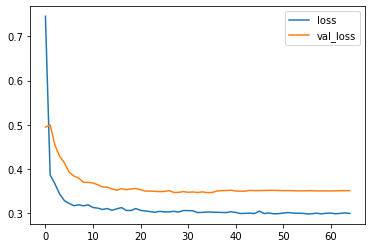

loss =  0.2992703914642334 , val_loss =  0.35084018111228943
Epoch 00065: early stopping
4/4 [==============================] - 1s 114ms/step - loss: 0.4534 - acc: 0.9558


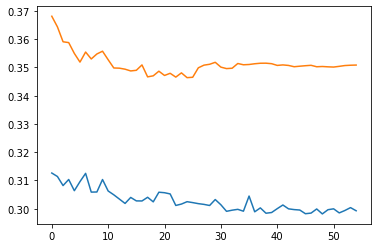

loss= 0.45337212085723877
acc= 0.9557521939277649


In [ ]:
hist = model.fit(
#     train_data_generator,
      train_x,
      train_y,
#       validation_data=test_data_generator,
      validation_split=0.1,
#       steps_per_epoch=train_data_generator.samples/64,  
      shuffle=True, 
#       validation_split=0.2,    
      batch_size=64,
      epochs=100,
      callbacks = callbacks,
      verbose = 1
#       class_weight = class_weight
)

loss, acc = model.evaluate(
      test_x,
      test_y
#       steps=test_data_generator.samples/64
)

plt.plot(hist.history['loss'][10:])
plt.plot(hist.history['val_loss'][10:])
plt.show()

print("loss=", loss)
print("acc=", acc)

## 히든레이어 120 x 120

In [ ]:
conv_layers = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
conv_layers.trainable = False

model = models.Sequential()

model.add(conv_layers)
model.add(layers.Flatten())
model.add(layers.Dense(120, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(120, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(2, activation='softmax'))

# optimizer = Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
model.compile(loss='sparse_categorical_crossentropy', optimizer='SGD', metrics=['acc'])


model.summary()

Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten_39 (Flatten)         (None, 62720)             0         
_________________________________________________________________
dense_114 (Dense)            (None, 120)               7526520   
_________________________________________________________________
batch_normalization_87 (Batc (None, 120)               480       
_________________________________________________________________
dropout_75 (Dropout)         (None, 120)               0         
_________________________________________________________________
dense_115 (Dense)            (None, 120)               14520     
_________________________________________________________________
batch_normalization_88 (Batc (None, 120)             

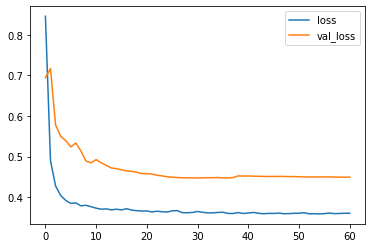

loss =  0.36044031381607056 , val_loss =  0.4495505094528198
Epoch 00061: early stopping
4/4 [==============================] - 0s 61ms/step - loss: 0.5083 - acc: 0.9292


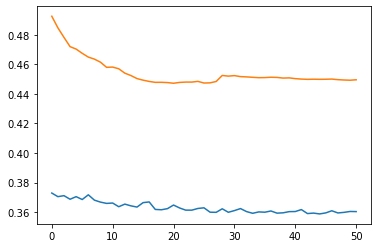

loss= 0.5082854628562927
acc= 0.9292035102844238


In [ ]:
hist = model.fit(
#     train_data_generator,
      train_x,
      train_y,
#       validation_data=test_data_generator,
      validation_split=0.1,
#       steps_per_epoch=train_data_generator.samples/64,  
      shuffle=True, 
#       validation_split=0.2,    
      batch_size=64,
      epochs=100,
      callbacks = callbacks,
      verbose = 1
#       class_weight = class_weight
)

loss, acc = model.evaluate(
      test_x,
      test_y
#       steps=test_data_generator.samples/64
)

plt.plot(hist.history['loss'][10:])
plt.plot(hist.history['val_loss'][10:])
plt.show()

print("loss=", loss)
print("acc=", acc)

## 히든레이어 80 x 80

In [ ]:
conv_layers = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
conv_layers.trainable = False

model = models.Sequential()

model.add(conv_layers)
model.add(layers.Flatten())
model.add(layers.Dense(80, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(80, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(2, activation='softmax'))

# optimizer = Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
model.compile(loss='sparse_categorical_crossentropy', optimizer='SGD', metrics=['acc'])


model.summary()

Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten_40 (Flatten)         (None, 62720)             0         
_________________________________________________________________
dense_117 (Dense)            (None, 80)                5017680   
_________________________________________________________________
batch_normalization_89 (Batc (None, 80)                320       
_________________________________________________________________
dropout_77 (Dropout)         (None, 80)                0         
_________________________________________________________________
dense_118 (Dense)            (None, 80)                6480      
_________________________________________________________________
batch_normalization_90 (Batc (None, 80)              

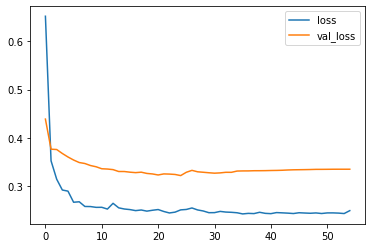

loss =  0.24862658977508545 , val_loss =  0.3346373736858368
Epoch 00055: early stopping
4/4 [==============================] - 0s 56ms/step - loss: 0.4168 - acc: 0.9646


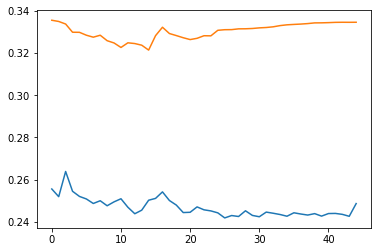

loss= 0.41676580905914307
acc= 0.9646017551422119


In [ ]:
hist = model.fit(
#     train_data_generator,
      train_x,
      train_y,
#       validation_data=test_data_generator,
      validation_split=0.1,
#       steps_per_epoch=train_data_generator.samples/64,  
      shuffle=True, 
#       validation_split=0.2,    
      batch_size=64,
      epochs=100,
      callbacks = callbacks,
      verbose = 1
#       class_weight = class_weight
)

loss, acc = model.evaluate(
      test_x,
      test_y
#       steps=test_data_generator.samples/64
)

plt.plot(hist.history['loss'][10:])
plt.plot(hist.history['val_loss'][10:])
plt.show()

print("loss=", loss)
print("acc=", acc)

## 히든레이어 60 x 60

In [ ]:
conv_layers = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
conv_layers.trainable = False

model = models.Sequential()

model.add(conv_layers)
model.add(layers.Flatten())
model.add(layers.Dense(60, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(60, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(2, activation='softmax'))

# optimizer = Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
model.compile(loss='sparse_categorical_crossentropy', optimizer='SGD', metrics=['acc'])


model.summary()

Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten_41 (Flatten)         (None, 62720)             0         
_________________________________________________________________
dense_120 (Dense)            (None, 60)                3763260   
_________________________________________________________________
batch_normalization_91 (Batc (None, 60)                240       
_________________________________________________________________
dropout_79 (Dropout)         (None, 60)                0         
_________________________________________________________________
dense_121 (Dense)            (None, 60)                3660      
_________________________________________________________________
batch_normalization_92 (Batc (None, 60)              

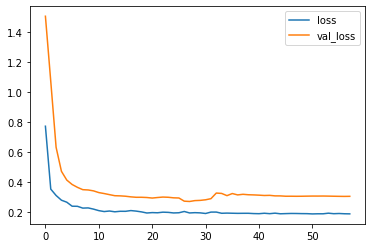

loss =  0.18557894229888916 , val_loss =  0.3025107979774475
Epoch 00058: early stopping
4/4 [==============================] - 0s 55ms/step - loss: 0.3544 - acc: 0.9292


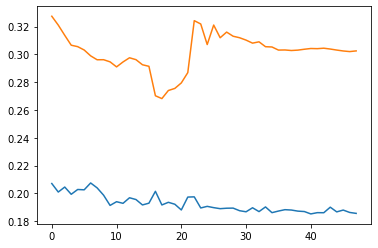

loss= 0.3543713390827179
acc= 0.9292035102844238


In [ ]:
hist = model.fit(
#     train_data_generator,
      train_x,
      train_y,
#       validation_data=test_data_generator,
      validation_split=0.1,
#       steps_per_epoch=train_data_generator.samples/64,  
      shuffle=True, 
#       validation_split=0.2,    
      batch_size=64,
      epochs=100,
      callbacks = callbacks,
      verbose = 1
#       class_weight = class_weight
)

loss, acc = model.evaluate(
      test_x,
      test_y
#       steps=test_data_generator.samples/64
)

plt.plot(hist.history['loss'][10:])
plt.plot(hist.history['val_loss'][10:])
plt.show()

print("loss=", loss)
print("acc=", acc)

## 히든레이어 40 x 40

In [ ]:
conv_layers = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
conv_layers.trainable = False

model = models.Sequential()

model.add(conv_layers)
model.add(layers.Flatten())
model.add(layers.Dense(40, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(40, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(2, activation='softmax'))

# optimizer = Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
model.compile(loss='sparse_categorical_crossentropy', optimizer='SGD', metrics=['acc'])


model.summary()

Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten_42 (Flatten)         (None, 62720)             0         
_________________________________________________________________
dense_123 (Dense)            (None, 40)                2508840   
_________________________________________________________________
batch_normalization_93 (Batc (None, 40)                160       
_________________________________________________________________
dropout_81 (Dropout)         (None, 40)                0         
_________________________________________________________________
dense_124 (Dense)            (None, 40)                1640      
_________________________________________________________________
batch_normalization_94 (Batc (None, 40)              

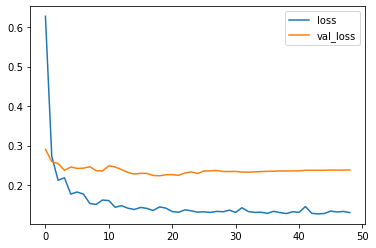

loss =  0.13000065088272095 , val_loss =  0.23796366155147552
Epoch 00049: early stopping
4/4 [==============================] - 0s 56ms/step - loss: 0.2666 - acc: 0.9558


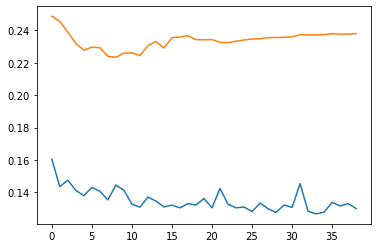

loss= 0.2665810286998749
acc= 0.9557521939277649


In [ ]:
hist = model.fit(
#     train_data_generator,
      train_x,
      train_y,
#       validation_data=test_data_generator,
      validation_split=0.1,
#       steps_per_epoch=train_data_generator.samples/64,  
      shuffle=True, 
#       validation_split=0.2,    
      batch_size=64,
      epochs=100,
      callbacks = callbacks,
      verbose = 1
#       class_weight = class_weight
)

loss, acc = model.evaluate(
      test_x,
      test_y
#       steps=test_data_generator.samples/64
)

plt.plot(hist.history['loss'][10:])
plt.plot(hist.history['val_loss'][10:])
plt.show()

print("loss=", loss)
print("acc=", acc)

 ## 히든레이어 20 x 20

In [ ]:
conv_layers = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
conv_layers.trainable = False

model = models.Sequential()

model.add(conv_layers)
model.add(layers.Flatten())
model.add(layers.Dense(20, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(20, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(2, activation='softmax'))

# optimizer = Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
model.compile(loss='sparse_categorical_crossentropy', optimizer='SGD', metrics=['acc'])


model.summary()

Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten_43 (Flatten)         (None, 62720)             0         
_________________________________________________________________
dense_126 (Dense)            (None, 20)                1254420   
_________________________________________________________________
batch_normalization_95 (Batc (None, 20)                80        
_________________________________________________________________
dropout_83 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_127 (Dense)            (None, 20)                420       
_________________________________________________________________
batch_normalization_96 (Batc (None, 20)              

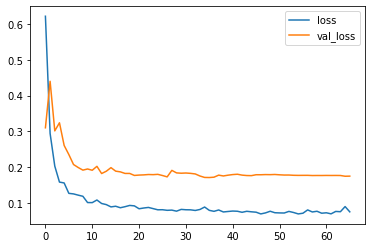

loss =  0.07587895542383194 , val_loss =  0.17544418573379517
Epoch 00066: early stopping
4/4 [==============================] - 0s 58ms/step - loss: 0.2316 - acc: 0.9558


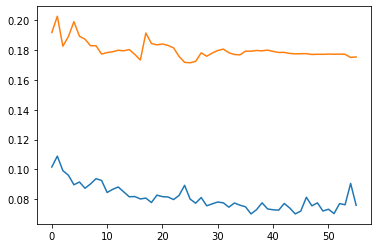

loss= 0.2316114604473114
acc= 0.9557521939277649


In [ ]:
hist = model.fit(
#     train_data_generator,
      train_x,
      train_y,
#       validation_data=test_data_generator,
      validation_split=0.1,
#       steps_per_epoch=train_data_generator.samples/64,  
      shuffle=True, 
#       validation_split=0.2,    
      batch_size=64,
      epochs=100,
      callbacks = callbacks,
      verbose = 1
#       class_weight = class_weight
)

loss, acc = model.evaluate(
      test_x,
      test_y
#       steps=test_data_generator.samples/64
)

plt.plot(hist.history['loss'][10:])
plt.plot(hist.history['val_loss'][10:])
plt.show()

print("loss=", loss)
print("acc=", acc)

## 히든레이어 10 x 10

In [ ]:
conv_layers = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
conv_layers.trainable = False

model = models.Sequential()

model.add(conv_layers)
model.add(layers.Flatten())
model.add(layers.Dense(10, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(10, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(2, activation='softmax'))

# optimizer = Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
model.compile(loss='sparse_categorical_crossentropy', optimizer='SGD', metrics=['acc'])


model.summary()

Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten_44 (Flatten)         (None, 62720)             0         
_________________________________________________________________
dense_129 (Dense)            (None, 10)                627210    
_________________________________________________________________
batch_normalization_97 (Batc (None, 10)                40        
_________________________________________________________________
dropout_85 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_130 (Dense)            (None, 10)                110       
_________________________________________________________________
batch_normalization_98 (Batc (None, 10)              

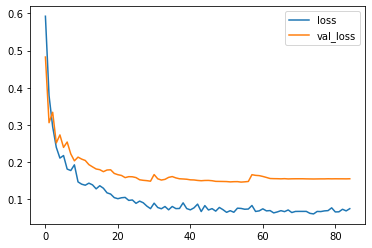

loss =  0.07494164258241653 , val_loss =  0.15529869496822357
Epoch 00085: early stopping
4/4 [==============================] - 0s 59ms/step - loss: 0.1779 - acc: 0.9469


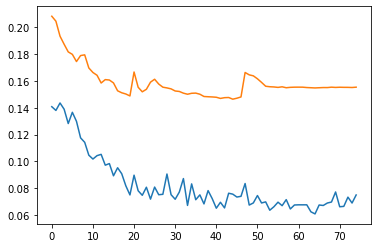

loss= 0.17791570723056793
acc= 0.9469026327133179


In [ ]:
hist = model.fit(
#     train_data_generator,
      train_x,
      train_y,
#       validation_data=test_data_generator,
      validation_split=0.1,
#       steps_per_epoch=train_data_generator.samples/64,  
      shuffle=True, 
#       validation_split=0.2,    
      batch_size=64,
      epochs=100,
      callbacks = callbacks,
      verbose = 1
#       class_weight = class_weight
)

loss, acc = model.evaluate(
      test_x,
      test_y
#       steps=test_data_generator.samples/64
)

plt.plot(hist.history['loss'][10:])
plt.plot(hist.history['val_loss'][10:])
plt.show()

print("loss=", loss)
print("acc=", acc)

## train 데이터 증강

In [ ]:
(raw_train_x, raw_train_y), (raw_test_x, raw_test_y), custom_labels = load_custom_data("data/2flowers_")

pre_train_x = mobilenet_v2.preprocess_input(raw_train_x)
test_x = mobilenet_v2.preprocess_input(raw_test_x)
pre_train_y = raw_train_y
test_y = raw_test_y

print(pre_train_x.shape)
print(pre_train_y.shape)
print(test_x.shape)
print(test_y.shape)
print(custom_labels)  

(451, 224, 224, 3)
(451,)
(113, 224, 224, 3)
(113,)
['daisy' 'dandelion']


In [ ]:
from sklearn.model_selection import train_test_split

train_x, validation_x, train_y, validation_y = train_test_split(pre_train_x, pre_train_y, test_size=0.1, random_state=42)
print(train_x.shape)
print(train_y.shape)
print(validation_x.shape)
print(validation_y.shape)
print(custom_labels)  

(405, 224, 224, 3)
(405,)
(46, 224, 224, 3)
(46,)
['daisy' 'dandelion']


In [ ]:
conv_layers = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
conv_layers.trainable = False

model = models.Sequential()

model.add(conv_layers)
model.add(layers.Flatten())
model.add(layers.Dense(100, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(100, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(2, activation='softmax'))

# optimizer = Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
model.compile(loss='sparse_categorical_crossentropy', optimizer='SGD', metrics=['acc'])


data_aug_generator = ImageDataGenerator(
      rotation_range=10,
      width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True,
      vertical_flip=False,
      preprocessing_function=vgg16.preprocess_input # 여기에 preprocess 함수를 설정
)
# test_data_generator = ImageDataGenerator(
#       preprocessing_function=vgg16.preprocess_input
# ).flow_from_directory(
#       "data/2flowers/test",
#       target_size=(224,224),
#       batch_size=64,
#       class_mode='sparse'
# )

model.summary()

Model: "sequential_52"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten_52 (Flatten)         (None, 62720)             0         
_________________________________________________________________
dense_153 (Dense)            (None, 100)               6272100   
_________________________________________________________________
batch_normalization_113 (Bat (None, 100)               400       
_________________________________________________________________
dropout_101 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_154 (Dense)            (None, 100)               10100     
_________________________________________________________________
batch_normalization_114 (Bat (None, 100)             

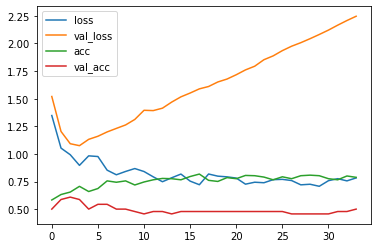

loss =  0.7825621962547302 , val_loss =  2.246220350265503
acc =  0.7876543402671814 , val_acc =  0.5
Epoch 00034: early stopping
4/4 [==============================] - 0s 52ms/step - loss: 1.6945 - acc: 0.5664


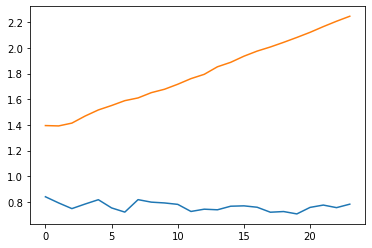

loss= 1.694474458694458
acc= 0.5663716793060303


In [ ]:
hist = model.fit(
      data_aug_generator.flow(train_x, train_y, batch_size=64),
      validation_data=(validation_x, validation_y),
      steps_per_epoch=train_x.shape[0]/64,
      shuffle=True, 
#       validation_split=0.2,    
#       batch_size=64,
      epochs=100,
      callbacks = callbacks,
#       class_weight = class_weight
)

loss, acc = model.evaluate(
      test_x,
      test_y
#       steps=test_data_generator.samples/64
)

plt.plot(hist.history['loss'][10:])
plt.plot(hist.history['val_loss'][10:])
plt.show()

print("loss=", loss)
print("acc=", acc)

## 손실함수를 RMSprop로 설정

In [ ]:
(train_x, train_y), (test_x, test_y), custom_labels = load_custom_data("data/2flowers_")

train_x = mobilenet_v2.preprocess_input(train_x)
test_x = mobilenet_v2.preprocess_input(test_x)

print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)
print(custom_labels)  

(451, 224, 224, 3)
(451,)
(113, 224, 224, 3)
(113,)
['daisy' 'dandelion']


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# callbacks
model_check_point = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)
plot_losses = PlotLosses()
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.00001)

callbacks = [model_check_point, plot_losses, early_stopping, reduce_lr]

In [ ]:
conv_layers = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
conv_layers.trainable = False

model = models.Sequential()

model.add(conv_layers)
model.add(layers.Flatten())
model.add(layers.Dense(100, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(100, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(2, activation='softmax'))

# optimizer = Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
model.compile(loss='sparse_categorical_crossentropy', optimizer='RMSprop', metrics=['acc'])


model.summary()

Model: "sequential_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten_54 (Flatten)         (None, 62720)             0         
_________________________________________________________________
dense_159 (Dense)            (None, 100)               6272100   
_________________________________________________________________
batch_normalization_117 (Bat (None, 100)               400       
_________________________________________________________________
dropout_105 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_160 (Dense)            (None, 100)               10100     
_________________________________________________________________
batch_normalization_118 (Bat (None, 100)             

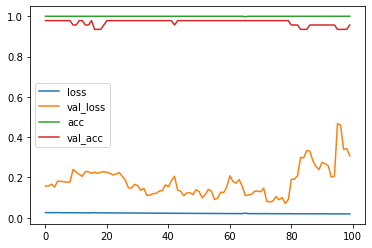

loss =  0.018924804404377937 , val_loss =  0.3072207570075989
acc =  1.0 , val_acc =  0.95652174949646
4/4 [==============================] - 0s 57ms/step - loss: 0.2460 - acc: 0.9469


NameError: name 'subplot' is not defined

In [ ]:
hist = model.fit(
#     train_data_generator,
      train_x,
      train_y,
#       validation_data=test_data_generator,
      validation_split=0.1,
#       steps_per_epoch=train_data_generator.samples/64,  
      shuffle=True, 
#       validation_split=0.2,    
      batch_size=64,
      epochs=100,
      callbacks = callbacks,
      verbose = 1
#       class_weight = class_weight
)

loss, acc = model.evaluate(
      test_x,
      test_y
#       steps=test_data_generator.samples/64
)

plt.plot(hist.history['loss'][10:])
plt.plot(hist.history['val_loss'][10:])
plt.show()

print("loss=", loss)
print("acc=", acc)

## 손실함수를 adam으로 설정

In [ ]:
conv_layers = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
conv_layers.trainable = False

model = models.Sequential()

model.add(conv_layers)
model.add(layers.Flatten())
model.add(layers.Dense(100, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(100, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(2, activation='softmax'))

# optimizer = Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['acc'])


model.summary()

Model: "sequential_55"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten_55 (Flatten)         (None, 62720)             0         
_________________________________________________________________
dense_162 (Dense)            (None, 100)               6272100   
_________________________________________________________________
batch_normalization_119 (Bat (None, 100)               400       
_________________________________________________________________
dropout_107 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_163 (Dense)            (None, 100)               10100     
_________________________________________________________________
batch_normalization_120 (Bat (None, 100)             

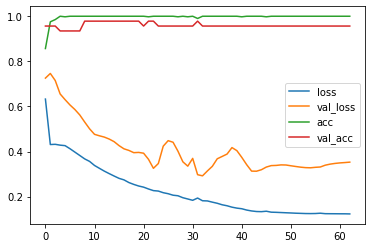

loss =  0.12330787628889084 , val_loss =  0.35289859771728516
acc =  1.0 , val_acc =  0.95652174949646
Epoch 00063: early stopping
4/4 [==============================] - 0s 57ms/step - loss: 0.2984 - acc: 0.9469


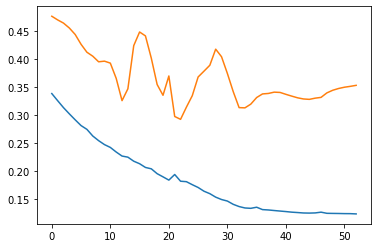

loss= 0.2983999252319336
acc= 0.9469026327133179


In [ ]:
hist = model.fit(
#     train_data_generator,
      train_x,
      train_y,
#       validation_data=test_data_generator,
      validation_split=0.1,
#       steps_per_epoch=train_data_generator.samples/64,  
      shuffle=True, 
#       validation_split=0.2,    
      batch_size=64,
      epochs=100,
      callbacks = callbacks,
      verbose = 1
#       class_weight = class_weight
)

loss, acc = model.evaluate(
      test_x,
      test_y
#       steps=test_data_generator.samples/64
)

plt.plot(hist.history['loss'][10:])
plt.plot(hist.history['val_loss'][10:])
plt.show()

print("loss=", loss)
print("acc=", acc)

## 손실함수를 Adadelta로 설정

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# callbacks
model_check_point = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)
plot_losses = PlotLosses()
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.00001)

callbacks = [model_check_point, plot_losses, early_stopping, reduce_lr]

In [ ]:
conv_layers = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
conv_layers.trainable = False

model = models.Sequential()

model.add(conv_layers)
model.add(layers.Flatten())
model.add(layers.Dense(100, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(100, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(2, activation='softmax'))

# optimizer = Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
model.compile(loss='sparse_categorical_crossentropy', optimizer='adadelta', metrics=['acc'])


model.summary()

Model: "sequential_57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten_57 (Flatten)         (None, 62720)             0         
_________________________________________________________________
dense_168 (Dense)            (None, 100)               6272100   
_________________________________________________________________
batch_normalization_123 (Bat (None, 100)               400       
_________________________________________________________________
dropout_111 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_169 (Dense)            (None, 100)               10100     
_________________________________________________________________
batch_normalization_124 (Bat (None, 100)             

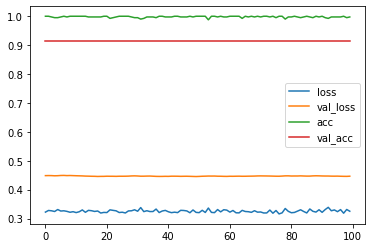

loss =  0.32531315088272095 , val_loss =  0.4465450644493103
acc =  0.9975308775901794 , val_acc =  0.9130434989929199
Epoch 00100: early stopping
4/4 [==============================] - 0s 56ms/step - loss: 0.5007 - acc: 0.9292


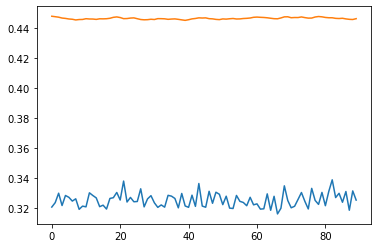

loss= 0.5006819367408752
acc= 0.9292035102844238


In [ ]:
hist = model.fit(
#     train_data_generator,
      train_x,
      train_y,
#       validation_data=test_data_generator,
      validation_split=0.1,
#       steps_per_epoch=train_data_generator.samples/64,  
      shuffle=True, 
#       validation_split=0.2,    
      batch_size=64,
      epochs=100,
      callbacks = callbacks,
      verbose = 1
#       class_weight = class_weight
)

loss, acc = model.evaluate(
      test_x,
      test_y
#       steps=test_data_generator.samples/64
)

plt.plot(hist.history['loss'][10:])
plt.plot(hist.history['val_loss'][10:])
plt.show()

print("loss=", loss)
print("acc=", acc)

## 손실함수를 Adamax로 설정

In [ ]:
conv_layers = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
conv_layers.trainable = False

model = models.Sequential()

model.add(conv_layers)
model.add(layers.Flatten())
model.add(layers.Dense(100, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(100, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(2, activation='softmax'))

# optimizer = Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
model.compile(loss='sparse_categorical_crossentropy', optimizer='adamax', metrics=['acc'])


model.summary()

Model: "sequential_79"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten_79 (Flatten)         (None, 62720)             0         
_________________________________________________________________
dense_234 (Dense)            (None, 100)               6272100   
_________________________________________________________________
batch_normalization_163 (Bat (None, 100)               400       
_________________________________________________________________
dropout_153 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_235 (Dense)            (None, 100)               10100     
_________________________________________________________________
batch_normalization_164 (Bat (None, 100)             

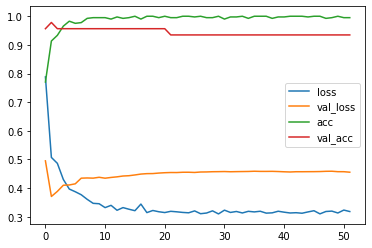

loss =  0.3183557987213135 , val_loss =  0.45562413334846497
acc =  0.9950617551803589 , val_acc =  0.9347826242446899
Epoch 00052: early stopping
4/4 [==============================] - 0s 57ms/step - loss: 0.3892 - acc: 0.9735


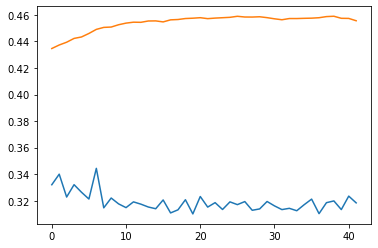

loss= 0.38920795917510986
acc= 0.9734513163566589


In [ ]:
hist = model.fit(
#     train_data_generator,
      train_x,
      train_y,
#       validation_data=test_data_generator,
      validation_split=0.1,
#       steps_per_epoch=train_data_generator.samples/64,  
      shuffle=True, 
#       validation_split=0.2,    
      batch_size=64,
      epochs=100,
      callbacks = callbacks,
      verbose = 1
#       class_weight = class_weight
)

loss, acc = model.evaluate(
      test_x,
      test_y
#       steps=test_data_generator.samples/64
)

plt.plot(hist.history['loss'][10:])
plt.plot(hist.history['val_loss'][10:])
plt.show()

print("loss=", loss)
print("acc=", acc)

## 손실함수를 Nadam으로 설정

In [ ]:
conv_layers = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
conv_layers.trainable = False

model = models.Sequential()

model.add(conv_layers)
model.add(layers.Flatten())
model.add(layers.Dense(100, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(100, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(2, activation='softmax'))

# optimizer = Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
model.compile(loss='sparse_categorical_crossentropy', optimizer='Nadam', metrics=['acc'])


model.summary()

Model: "sequential_59"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten_59 (Flatten)         (None, 62720)             0         
_________________________________________________________________
dense_174 (Dense)            (None, 100)               6272100   
_________________________________________________________________
batch_normalization_127 (Bat (None, 100)               400       
_________________________________________________________________
dropout_115 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_175 (Dense)            (None, 100)               10100     
_________________________________________________________________
batch_normalization_128 (Bat (None, 100)             

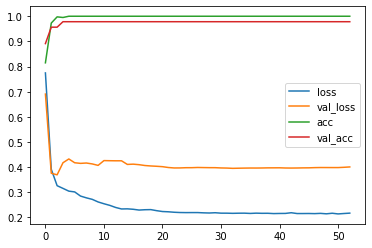

loss =  0.21722903847694397 , val_loss =  0.40089112520217896
acc =  1.0 , val_acc =  0.97826087474823
Epoch 00053: early stopping
4/4 [==============================] - 0s 56ms/step - loss: 0.3224 - acc: 0.9735


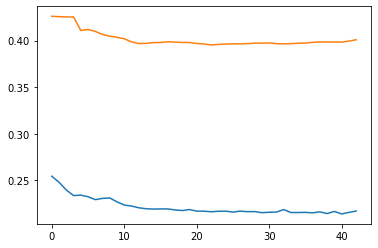

loss= 0.32237136363983154
acc= 0.9734513163566589


In [ ]:
hist = model.fit(
#     train_data_generator,
      train_x,
      train_y,
#       validation_data=test_data_generator,
      validation_split=0.1,
#       steps_per_epoch=train_data_generator.samples/64,  
      shuffle=True, 
#       validation_split=0.2,    
      batch_size=64,
      epochs=100,
      callbacks = callbacks,
      verbose = 1
#       class_weight = class_weight
)

loss, acc = model.evaluate(
      test_x,
      test_y
#       steps=test_data_generator.samples/64
)

plt.plot(hist.history['loss'][10:])
plt.plot(hist.history['val_loss'][10:])
plt.show()

print("loss=", loss)
print("acc=", acc)

## class_weight 설정

In [ ]:
unique, counts = np.unique(train_y, return_counts = True)
uniq_cnt_dict = dict(zip(unique, counts))
uniq_cnt_dict

{0: 212, 1: 239}

In [ ]:
class_weight ={0 : 1/uniq_cnt_dict[0], 1 : 1/uniq_cnt_dict[1] }
class_weight

{0: 0.0047169811320754715, 1: 0.0041841004184100415}

In [ ]:
conv_layers = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
conv_layers.trainable = False

model = models.Sequential()

model.add(conv_layers)
model.add(layers.Flatten())
model.add(layers.Dense(100, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(100, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(2, activation='softmax'))

# optimizer = Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
model.compile(loss='sparse_categorical_crossentropy', optimizer='Nadam', metrics=['acc'])


model.summary()

Model: "sequential_60"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten_60 (Flatten)         (None, 62720)             0         
_________________________________________________________________
dense_177 (Dense)            (None, 100)               6272100   
_________________________________________________________________
batch_normalization_129 (Bat (None, 100)               400       
_________________________________________________________________
dropout_117 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_178 (Dense)            (None, 100)               10100     
_________________________________________________________________
batch_normalization_130 (Bat (None, 100)             

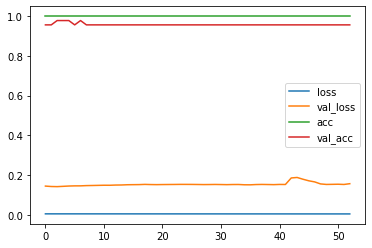

loss =  0.0038258559070527554 , val_loss =  0.15612293779850006
acc =  1.0 , val_acc =  0.95652174949646
Epoch 00053: early stopping
4/4 [==============================] - 0s 57ms/step - loss: 0.1602 - acc: 0.9646


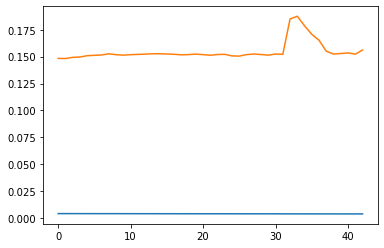

loss= 0.1602175384759903
acc= 0.9646017551422119


In [ ]:
hist = model.fit(
#     train_data_generator,
      train_x,
      train_y,
#       validation_data=test_data_generator,
      validation_split=0.1,
#       steps_per_epoch=train_data_generator.samples/64,  
      shuffle=True, 
#       validation_split=0.2,    
      batch_size=64,
      epochs=100,
      callbacks = callbacks,
      verbose = 1,
      class_weight = class_weight
)

loss, acc = model.evaluate(
      test_x,
      test_y
#       steps=test_data_generator.samples/64
)

plt.plot(hist.history['loss'][10:])
plt.plot(hist.history['val_loss'][10:])
plt.show()

print("loss=", loss)
print("acc=", acc)

## binary_crossentropy & sigmoid

In [ ]:
conv_layers = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
conv_layers.trainable = False

model = models.Sequential()

model.add(conv_layers)
model.add(layers.Flatten())
model.add(layers.Dense(100, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(100, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid'))

# optimizer = Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
model.compile(loss='binary_crossentropy', optimizer='adamax', metrics=['acc'])


model.summary()

Model: "sequential_63"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten_63 (Flatten)         (None, 62720)             0         
_________________________________________________________________
dense_186 (Dense)            (None, 100)               6272100   
_________________________________________________________________
batch_normalization_135 (Bat (None, 100)               400       
_________________________________________________________________
dropout_123 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_187 (Dense)            (None, 100)               10100     
_________________________________________________________________
batch_normalization_136 (Bat (None, 100)             

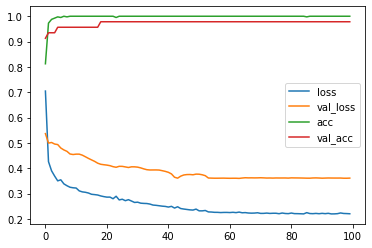

loss =  0.2201608419418335 , val_loss =  0.3608797788619995
acc =  1.0 , val_acc =  0.97826087474823
4/4 [==============================] - 0s 54ms/step - loss: 0.3557 - acc: 0.9292


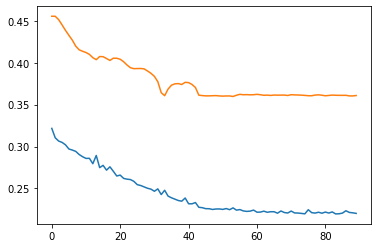

loss= 0.3556995093822479
acc= 0.9292035102844238


In [ ]:
hist = model.fit(
#     train_data_generator,
      train_x,
      train_y,
#       validation_data=test_data_generator,
      validation_split=0.1,
#       steps_per_epoch=train_data_generator.samples/64,  
      shuffle=True, 
#       validation_split=0.2,    
      batch_size=64,
      epochs=100,
      callbacks = callbacks,
      verbose = 1
#       class_weight = class_weight
)

loss, acc = model.evaluate(
      test_x,
      test_y
#       steps=test_data_generator.samples/64
)

plt.plot(hist.history['loss'][10:])
plt.plot(hist.history['val_loss'][10:])
plt.show()

print("loss=", loss)
print("acc=", acc)

## tanh

In [ ]:
conv_layers = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
conv_layers.trainable = False

model = models.Sequential()

model.add(conv_layers)
model.add(layers.Flatten())
model.add(layers.Dense(100, activation='tanh', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(100, activation='tanh', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(2, activation='softmax'))

# optimizer = Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
model.compile(loss='sparse_categorical_crossentropy', optimizer='adamax', metrics=['acc'])


model.summary()

Model: "sequential_64"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten_64 (Flatten)         (None, 62720)             0         
_________________________________________________________________
dense_189 (Dense)            (None, 100)               6272100   
_________________________________________________________________
batch_normalization_137 (Bat (None, 100)               400       
_________________________________________________________________
dropout_125 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_190 (Dense)            (None, 100)               10100     
_________________________________________________________________
batch_normalization_138 (Bat (None, 100)             

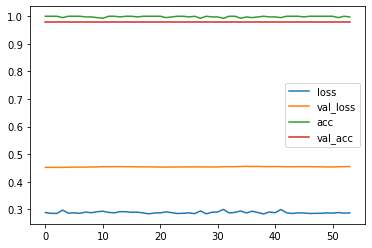

loss =  0.28730136156082153 , val_loss =  0.4552605152130127
acc =  0.9975308775901794 , val_acc =  0.97826087474823
Epoch 00054: early stopping
4/4 [==============================] - 0s 57ms/step - loss: 0.4165 - acc: 0.9558


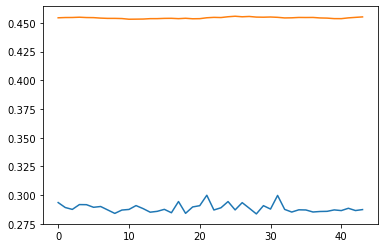

loss= 0.41653934121131897
acc= 0.9557521939277649


In [ ]:
hist = model.fit(
#     train_data_generator,
      train_x,
      train_y,
#       validation_data=test_data_generator,
      validation_split=0.1,
#       steps_per_epoch=train_data_generator.samples/64,  
      shuffle=True, 
#       validation_split=0.2,    
      batch_size=64,
      epochs=100,
      callbacks = callbacks,
      verbose = 1
#       class_weight = class_weight
)

loss, acc = model.evaluate(
      test_x,
      test_y
#       steps=test_data_generator.samples/64
)

plt.plot(hist.history['loss'][10:])
plt.plot(hist.history['val_loss'][10:])
plt.show()

print("loss=", loss)
print("acc=", acc)

## softsign

In [ ]:
conv_layers = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
conv_layers.trainable = False

model = models.Sequential()

model.add(conv_layers)
model.add(layers.Flatten())
model.add(layers.Dense(100, activation='softplus', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(100, activation='softplus', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(2, activation='softmax'))

# optimizer = Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
model.compile(loss='sparse_categorical_crossentropy', optimizer='adamax', metrics=['acc'])


model.summary()

Model: "sequential_66"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten_66 (Flatten)         (None, 62720)             0         
_________________________________________________________________
dense_195 (Dense)            (None, 100)               6272100   
_________________________________________________________________
batch_normalization_141 (Bat (None, 100)               400       
_________________________________________________________________
dropout_129 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_196 (Dense)            (None, 100)               10100     
_________________________________________________________________
batch_normalization_142 (Bat (None, 100)             

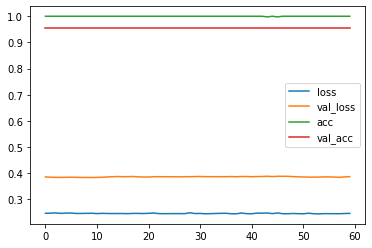

loss =  0.2461862415075302 , val_loss =  0.3867771029472351
acc =  1.0 , val_acc =  0.95652174949646
Epoch 00060: early stopping
4/4 [==============================] - 0s 57ms/step - loss: 0.3729 - acc: 0.9646


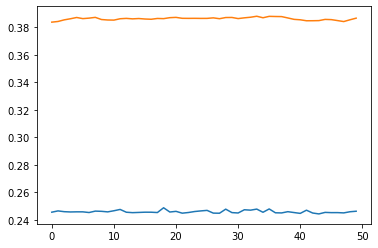

loss= 0.3728539049625397
acc= 0.9646017551422119


In [ ]:
hist = model.fit(
#     train_data_generator,
      train_x,
      train_y,
#       validation_data=test_data_generator,
      validation_split=0.1,
#       steps_per_epoch=train_data_generator.samples/64,  
      shuffle=True, 
#       validation_split=0.2,    
      batch_size=64,
      epochs=100,
      callbacks = callbacks,
      verbose = 1
#       class_weight = class_weight
)

loss, acc = model.evaluate(
      test_x,
      test_y
#       steps=test_data_generator.samples/64
)

plt.plot(hist.history['loss'][10:])
plt.plot(hist.history['val_loss'][10:])
plt.show()

print("loss=", loss)
print("acc=", acc)

## elu

In [ ]:
conv_layers = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
conv_layers.trainable = False

model = models.Sequential()

model.add(conv_layers)
model.add(layers.Flatten())
model.add(layers.Dense(100, activation='elu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(100, activation='elu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(2, activation='softmax'))

# optimizer = Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
model.compile(loss='sparse_categorical_crossentropy', optimizer='adamax', metrics=['acc'])


model.summary()

Model: "sequential_67"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten_67 (Flatten)         (None, 62720)             0         
_________________________________________________________________
dense_198 (Dense)            (None, 100)               6272100   
_________________________________________________________________
batch_normalization_143 (Bat (None, 100)               400       
_________________________________________________________________
dropout_131 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_199 (Dense)            (None, 100)               10100     
_________________________________________________________________
batch_normalization_144 (Bat (None, 100)             

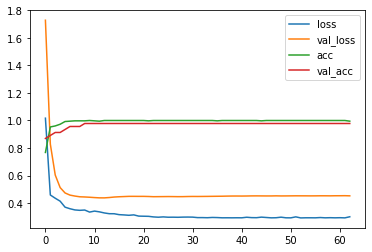

loss =  0.30060529708862305 , val_loss =  0.4527004361152649
acc =  0.9950617551803589 , val_acc =  0.97826087474823
Epoch 00063: early stopping
4/4 [==============================] - 0s 55ms/step - loss: 0.4207 - acc: 0.9558


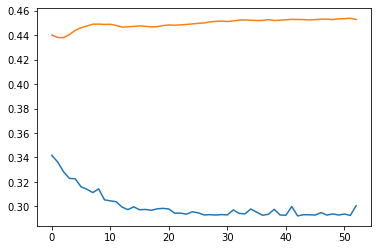

loss= 0.4207046627998352
acc= 0.9557521939277649


In [ ]:
hist = model.fit(
#     train_data_generator,
      train_x,
      train_y,
#       validation_data=test_data_generator,
      validation_split=0.1,
#       steps_per_epoch=train_data_generator.samples/64,  
      shuffle=True, 
#       validation_split=0.2,    
      batch_size=64,
      epochs=100,
      callbacks = callbacks,
      verbose = 1
#       class_weight = class_weight
)

loss, acc = model.evaluate(
      test_x,
      test_y
#       steps=test_data_generator.samples/64
)

plt.plot(hist.history['loss'][10:])
plt.plot(hist.history['val_loss'][10:])
plt.show()

print("loss=", loss)
print("acc=", acc)

## selu

In [ ]:
conv_layers = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
conv_layers.trainable = False

model = models.Sequential()

model.add(conv_layers)
model.add(layers.Flatten())
model.add(layers.Dense(100, activation='selu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(100, activation='selu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(2, activation='softmax'))

# optimizer = Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
model.compile(loss='sparse_categorical_crossentropy', optimizer='adamax', metrics=['acc'])


model.summary()

Model: "sequential_68"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten_68 (Flatten)         (None, 62720)             0         
_________________________________________________________________
dense_201 (Dense)            (None, 100)               6272100   
_________________________________________________________________
batch_normalization_145 (Bat (None, 100)               400       
_________________________________________________________________
dropout_133 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_202 (Dense)            (None, 100)               10100     
_________________________________________________________________
batch_normalization_146 (Bat (None, 100)             

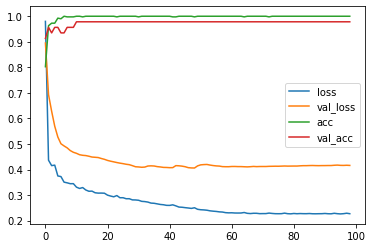

loss =  0.22710038721561432 , val_loss =  0.4161054491996765
acc =  1.0 , val_acc =  0.97826087474823
Epoch 00099: early stopping
4/4 [==============================] - 0s 58ms/step - loss: 0.3552 - acc: 0.9558


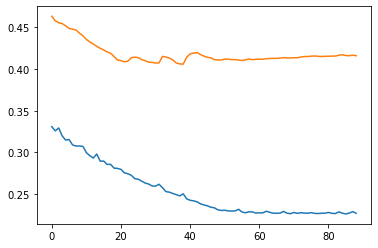

loss= 0.3551611006259918
acc= 0.9557521939277649


In [ ]:
hist = model.fit(
#     train_data_generator,
      train_x,
      train_y,
#       validation_data=test_data_generator,
      validation_split=0.1,
#       steps_per_epoch=train_data_generator.samples/64,  
      shuffle=True, 
#       validation_split=0.2,    
      batch_size=64,
      epochs=100,
      callbacks = callbacks,
      verbose = 1
#       class_weight = class_weight
)

loss, acc = model.evaluate(
      test_x,
      test_y
#       steps=test_data_generator.samples/64
)

plt.plot(hist.history['loss'][10:])
plt.plot(hist.history['val_loss'][10:])
plt.show()

print("loss=", loss)
print("acc=", acc)

## 고급 활성화함수 LeakyReLU

In [ ]:
conv_layers = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
conv_layers.trainable = False

model = models.Sequential()

model.add(conv_layers)
model.add(layers.Flatten())
model.add(layers.Dense(100, activation='LeakyReLU', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(100, activation='LeakyReLU', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(2, activation='softmax'))

# optimizer = Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
model.compile(loss='sparse_categorical_crossentropy', optimizer='adamax', metrics=['acc'])


model.summary()

Model: "sequential_69"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten_69 (Flatten)         (None, 62720)             0         
_________________________________________________________________
dense_204 (Dense)            (None, 100)               6272100   
_________________________________________________________________
batch_normalization_147 (Bat (None, 100)               400       
_________________________________________________________________
dropout_135 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_205 (Dense)            (None, 100)               10100     
_________________________________________________________________
batch_normalization_148 (Bat (None, 100)             

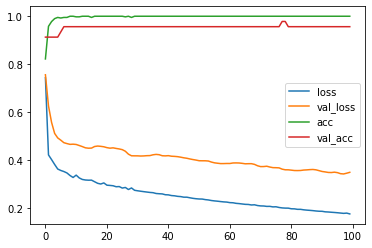

loss =  0.1770269274711609 , val_loss =  0.35020625591278076
acc =  1.0 , val_acc =  0.95652174949646
4/4 [==============================] - 0s 56ms/step - loss: 0.3202 - acc: 0.9558


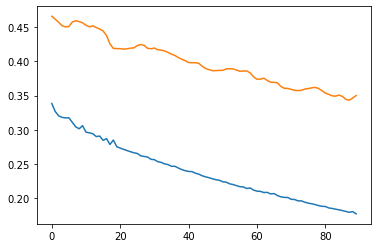

loss= 0.32018977403640747
acc= 0.9557521939277649


In [ ]:
hist = model.fit(
#     train_data_generator,
      train_x,
      train_y,
#       validation_data=test_data_generator,
      validation_split=0.1,
#       steps_per_epoch=train_data_generator.samples/64,  
      shuffle=True, 
#       validation_split=0.2,    
      batch_size=64,
      epochs=100,
      callbacks = callbacks,
      verbose = 1
#       class_weight = class_weight
)

loss, acc = model.evaluate(
      test_x,
      test_y
#       steps=test_data_generator.samples/64
)

plt.plot(hist.history['loss'][10:])
plt.plot(hist.history['val_loss'][10:])
plt.show()

print("loss=", loss)
print("acc=", acc)

## PReLU

In [ ]:
conv_layers = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
conv_layers.trainable = False

model = models.Sequential()

model.add(conv_layers)
model.add(layers.Flatten())
model.add(layers.Dense(100, activation='hard_sigmoid', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(100, activation='hard_sigmoid', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(2, activation='softmax'))

# optimizer = Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
model.compile(loss='sparse_categorical_crossentropy', optimizer='adamax', metrics=['acc'])


model.summary()

Model: "sequential_72"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten_72 (Flatten)         (None, 62720)             0         
_________________________________________________________________
dense_213 (Dense)            (None, 100)               6272100   
_________________________________________________________________
batch_normalization_153 (Bat (None, 100)               400       
_________________________________________________________________
dropout_141 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_214 (Dense)            (None, 100)               10100     
_________________________________________________________________
batch_normalization_154 (Bat (None, 100)             

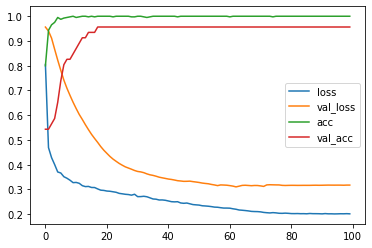

loss =  0.20162327587604523 , val_loss =  0.31773144006729126
acc =  1.0 , val_acc =  0.95652174949646
4/4 [==============================] - 0s 57ms/step - loss: 0.3527 - acc: 0.9558


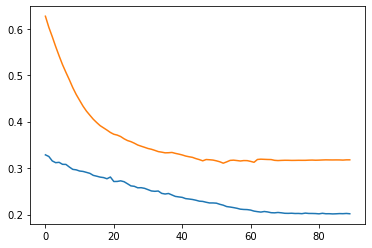

loss= 0.3526512682437897
acc= 0.9557521939277649


In [ ]:
hist = model.fit(
#     train_data_generator,
      train_x,
      train_y,
#       validation_data=test_data_generator,
      validation_split=0.1,
#       steps_per_epoch=train_data_generator.samples/64,  
      shuffle=True, 
#       validation_split=0.2,    
      batch_size=64,
      epochs=100,
      callbacks = callbacks,
      verbose = 1
#       class_weight = class_weight
)

loss, acc = model.evaluate(
      test_x,
      test_y
#       steps=test_data_generator.samples/64
)

plt.plot(hist.history['loss'][10:])
plt.plot(hist.history['val_loss'][10:])
plt.show()

print("loss=", loss)
print("acc=", acc)

# NASNetMobile

## 히든레이어 100 x 100

In [ ]:
from tensorflow.keras.applications import NASNetMobile
from tensorflow.keras.applications import nasnet

In [ ]:
(train_x, train_y), (test_x, test_y), custom_labels = load_custom_data("data/2flowers_")

train_x = nasnet.preprocess_input(train_x)
test_x = nasnet.preprocess_input(test_x)

print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)
print(custom_labels)  

(451, 224, 224, 3)
(451,)
(113, 224, 224, 3)
(113,)
['daisy' 'dandelion']


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# callbacks
model_check_point = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)
plot_losses = PlotLosses()
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.00001)

callbacks = [model_check_point, plot_losses, early_stopping, reduce_lr]

In [ ]:
conv_layers = NASNetMobile(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
conv_layers.trainable = False

model = models.Sequential()

model.add(conv_layers)
model.add(layers.Flatten())
model.add(layers.Dense(100, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(100, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(2, activation='softmax'))

# optimizer = Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
model.compile(loss='sparse_categorical_crossentropy', optimizer='SGD', metrics=['acc'])


model.summary()

Model: "sequential_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
NASNet (Functional)          (None, 7, 7, 1056)        4269716   
_________________________________________________________________
flatten_49 (Flatten)         (None, 51744)             0         
_________________________________________________________________
dense_144 (Dense)            (None, 100)               5174500   
_________________________________________________________________
batch_normalization_107 (Bat (None, 100)               400       
_________________________________________________________________
dropout_95 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_145 (Dense)            (None, 100)               10100     
_________________________________________________________________
batch_normalization_108 (Bat (None, 100)             

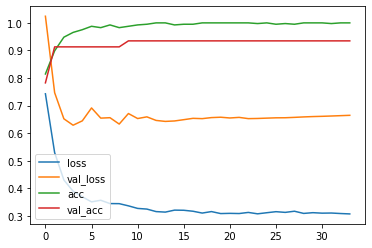

loss =  0.3075498938560486 , val_loss =  0.6649429798126221
acc =  1.0 , val_acc =  0.9347826242446899
Epoch 00034: early stopping
4/4 [==============================] - 0s 106ms/step - loss: 0.5477 - acc: 0.9292


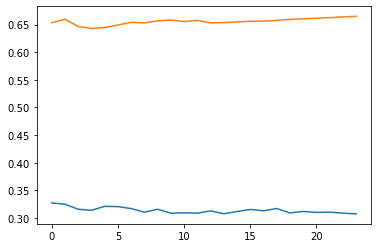

loss= 0.5476697683334351
acc= 0.9292035102844238


In [ ]:
hist = model.fit(
#     train_data_generator,
      train_x,
      train_y,
#       validation_data=test_data_generator,
      validation_split=0.1,
#       steps_per_epoch=train_data_generator.samples/64,  
      shuffle=True, 
#       validation_split=0.2,    
      batch_size=64,
      epochs=100,
      callbacks = callbacks,
      verbose = 1
#       class_weight = class_weight
)

loss, acc = model.evaluate(
      test_x,
      test_y
#       steps=test_data_generator.samples/64
)

plt.plot(hist.history['loss'][10:])
plt.plot(hist.history['val_loss'][10:])
plt.show()

print("loss=", loss)
print("acc=", acc)

## 히든레이어 120 x 120

In [ ]:
conv_layers = NASNetMobile(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
conv_layers.trainable = False

model = models.Sequential()

model.add(conv_layers)
model.add(layers.Flatten())
model.add(layers.Dense(120, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(120, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(2, activation='softmax'))

# optimizer = Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
model.compile(loss='sparse_categorical_crossentropy', optimizer='SGD', metrics=['acc'])


model.summary()

Model: "sequential_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
NASNet (Functional)          (None, 7, 7, 1056)        4269716   
_________________________________________________________________
flatten_50 (Flatten)         (None, 51744)             0         
_________________________________________________________________
dense_147 (Dense)            (None, 120)               6209400   
_________________________________________________________________
batch_normalization_109 (Bat (None, 120)               480       
_________________________________________________________________
dropout_97 (Dropout)         (None, 120)               0         
_________________________________________________________________
dense_148 (Dense)            (None, 120)               14520     
_________________________________________________________________
batch_normalization_110 (Bat (None, 120)             

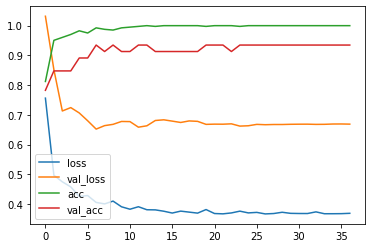

loss =  0.36896902322769165 , val_loss =  0.668851375579834
acc =  1.0 , val_acc =  0.9347826242446899
Epoch 00037: early stopping
4/4 [==============================] - 0s 106ms/step - loss: 0.5829 - acc: 0.9027


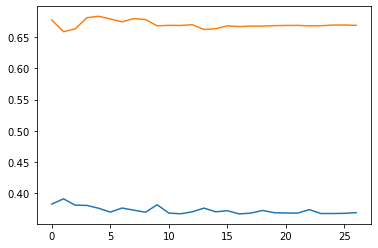

loss= 0.5829476118087769
acc= 0.9026548862457275


In [ ]:
hist = model.fit(
#     train_data_generator,
      train_x,
      train_y,
#       validation_data=test_data_generator,
      validation_split=0.1,
#       steps_per_epoch=train_data_generator.samples/64,  
      shuffle=True, 
#       validation_split=0.2,    
      batch_size=64,
      epochs=100,
      callbacks = callbacks,
      verbose = 1
#       class_weight = class_weight
)

loss, acc = model.evaluate(
      test_x,
      test_y
#       steps=test_data_generator.samples/64
)

plt.plot(hist.history['loss'][10:])
plt.plot(hist.history['val_loss'][10:])
plt.show()

print("loss=", loss)
print("acc=", acc)

## 히든레이어 80 x 80

In [ ]:
conv_layers = NASNetMobile(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
conv_layers.trainable = False

model = models.Sequential()

model.add(conv_layers)
model.add(layers.Flatten())
model.add(layers.Dense(80, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(80, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(2, activation='softmax'))

# optimizer = Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
model.compile(loss='sparse_categorical_crossentropy', optimizer='SGD', metrics=['acc'])


model.summary()

Model: "sequential_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
NASNet (Functional)          (None, 7, 7, 1056)        4269716   
_________________________________________________________________
flatten_51 (Flatten)         (None, 51744)             0         
_________________________________________________________________
dense_150 (Dense)            (None, 80)                4139600   
_________________________________________________________________
batch_normalization_111 (Bat (None, 80)                320       
_________________________________________________________________
dropout_99 (Dropout)         (None, 80)                0         
_________________________________________________________________
dense_151 (Dense)            (None, 80)                6480      
_________________________________________________________________
batch_normalization_112 (Bat (None, 80)              

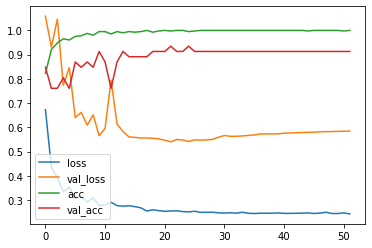

loss =  0.2424437403678894 , val_loss =  0.584306538105011
acc =  1.0 , val_acc =  0.9130434989929199
Epoch 00052: early stopping
4/4 [==============================] - 0s 103ms/step - loss: 0.5271 - acc: 0.9027


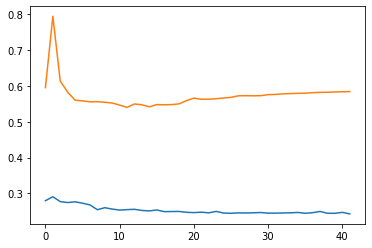

loss= 0.5271327495574951
acc= 0.9026548862457275


In [ ]:
hist = model.fit(
#     train_data_generator,
      train_x,
      train_y,
#       validation_data=test_data_generator,
      validation_split=0.1,
#       steps_per_epoch=train_data_generator.samples/64,  
      shuffle=True, 
#       validation_split=0.2,    
      batch_size=64,
      epochs=100,
      callbacks = callbacks,
      verbose = 1
#       class_weight = class_weight
)

loss, acc = model.evaluate(
      test_x,
      test_y
#       steps=test_data_generator.samples/64
)

plt.plot(hist.history['loss'][10:])
plt.plot(hist.history['val_loss'][10:])
plt.show()

print("loss=", loss)
print("acc=", acc)

# test data없이 훈련

In [ ]:
(train_x, train_y), (test_x, test_y), custom_labels = load_custom_data("data/2flowers_")

train_x = mobilenet_v2.preprocess_input(train_x)
test_x = mobilenet_v2.preprocess_input(test_x)

print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)
print(custom_labels)  

(451, 224, 224, 3)
(451,)
(113, 224, 224, 3)
(113,)
['daisy' 'dandelion']


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# callbacks
model_check_point = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)
plot_losses = PlotLosses()
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.0001)

callbacks = [model_check_point, plot_losses, early_stopping, reduce_lr]

In [ ]:
conv_layers = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
conv_layers.trainable = False

model = models.Sequential()

model.add(conv_layers)
model.add(layers.Flatten())
model.add(layers.Dense(100, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(100, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(2, activation='softmax'))

# optimizer = Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
model.compile(loss='sparse_categorical_crossentropy', optimizer='adamax', metrics=['acc'])


# train_data_generator = ImageDataGenerator(
#       rotation_range=10,
#       width_shift_range=0.1,
#       height_shift_range=0.1,
#       horizontal_flip=True,
#       vertical_flip=False,
#       preprocessing_function=vgg16.preprocess_input
# ).flow_from_directory(
#       "data/2flowers/train",
#       target_size=(224,224),
#       batch_size=64,
#       class_mode='sparse'
# )

# test_data_generator = ImageDataGenerator(
#       preprocessing_function=vgg16.preprocess_input
# ).flow_from_directory(
#       "data/2flowers/test",
#       target_size=(224,224),
#       batch_size=64,
#       class_mode='sparse'
# )

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten (Flatten)            (None, 62720)             0         
_________________________________________________________________
dense (Dense)                (None, 100)               6272100   
_________________________________________________________________
batch_normalization (BatchNo (None, 100)               400       
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
batch_normalization_1 (Batch (None, 100)               4

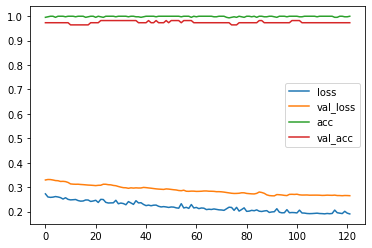

loss =  0.19017799198627472 , val_loss =  0.2648577392101288
acc =  1.0 , val_acc =  0.9734513163566589
Epoch 00122: early stopping
4/4 [==============================] - 0s 57ms/step - loss: 0.2649 - acc: 0.9735


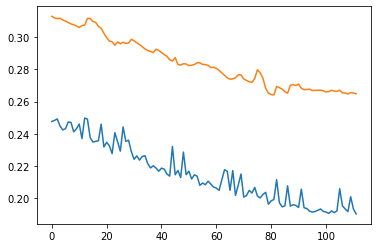

loss= 0.2648577392101288
acc= 0.9734513163566589


In [ ]:
hist = model.fit(
#     train_data_generator,
      train_x,
      train_y,
      validation_data=(test_x, test_y),
#       validation_split=0.1,
#       steps_per_epoch=train_data_generator.samples/64,  
      shuffle=True, 
#       validation_split=0.2,    
      batch_size=32,
      epochs=300,
      callbacks = callbacks,
#       class_weight = class_weight
)

loss, acc = model.evaluate(
      test_x,
      test_y
#       steps=test_data_generator.samples/64
)

plt.plot(hist.history['loss'][10:])
plt.plot(hist.history['val_loss'][10:])
plt.show()

print("loss=", loss)
print("acc=", acc)